In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import tensorflow.compat.v1 as tf
import numpy as np
import scipy
import pandas as pd

from generatorMT import BatchGeneratorFilterNew
import matplotlib.pyplot as plt

from IPython.display import clear_output
import matplotlib.pyplot as plt
from utils import *
from module import *
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# "Global" config variables

In [3]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
model_name='SubjectVsGender_EIGAN'
pretrain_checkpoint_dir='basecheckpoint_eigan' #dir with checkpoints for the pretrain nw
train_checkpoint_dir='checkpoint_eigan' #dir with checkpoints for the trained nw
use_batchnorm_classifiers=True
use_batchnorm_filter =False
image_size=128
n_channels=1
load_pretrained_classifiers=False
pretrain_classifiers=True
load_pretrained_filter=False
pretrain_filter=True

# import data pickles

In [5]:
df =pd.read_pickle('Facescrub_pandas_reduced.pkl')

In [6]:
df.head(2)

,index,filepath,subject_str,gender_str,subject_number,gender_number
165,165,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1
166,166,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1


In [7]:
subjects = {}
for idx, _ in df.iterrows():
    subjects[_['subject_str']] = _['subject_number']
print('Number of subjects: {}'.format(len(subjects)))

Number of subjects: 200


In [8]:
male = {}
female = {}
data = {}
for type_, dict_ in zip(['actors', 'actresses'], [male, female]):
    with open('../facescrub/facescrub_{}.txt'.format(type_), 'r') as file:
        line = file.readline()
        line = file.readline()
        while line:
            dict_[line.split('\t')[0].replace(' ', '_')]=True
            line = file.readline()
print("Number of males: {}\nNumber of females: {}".format(len(male), len(female)))

Number of males: 265
Number of females: 265


In [9]:
data_path = '/data/FaceScrub/'
data = []
for person in os.listdir(data_path):
    facepath = os.path.join(data_path, person, 'face')
    gender = 'female'
    gender_number = 1
    person_str = person.replace(' ', '_')
    if person_str in subjects:
        if person_str in male:
            gender = 'male'
            gender_number = 0
        for image in os.listdir(facepath):
            data.append([os.path.join(facepath, image), person_str, gender, subjects[person_str], gender_number])

df_new = pd.DataFrame(data, columns=['filepath', 'subject_str', 'gender_str', 'subject_number', 'gender_number'])
df_new.head(2)

,filepath,subject_str,gender_str,subject_number,gender_number
0,/data/FaceScrub/Joe_Manganiello/face/ccc38a04b...,Joe_Manganiello,male,184,0
1,/data/FaceScrub/Joe_Manganiello/face/72b2d4b6c...,Joe_Manganiello,male,184,0


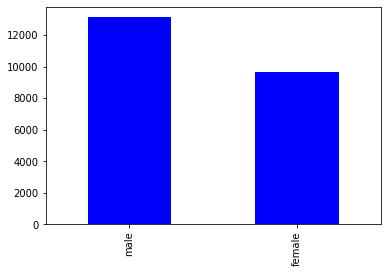

In [10]:
df_new.gender_str.value_counts().plot(kind='bar', color='b')
plt.show()

In [11]:
df['systempath'] = df.filepath.apply(
    lambda x: '/'.join(['/WorkSpace/FaceScrub/images'] + x.split('/')[3:]))
df['isvalidpath'] = df.systempath.apply(os.path.isfile)
df.head()

,index,filepath,subject_str,gender_str,subject_number,gender_number,systempath,isvalidpath
165,165,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1,/WorkSpace/FaceScrub/images/Sarah_Michelle_Gel...,False
166,166,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1,/WorkSpace/FaceScrub/images/Sarah_Michelle_Gel...,False
167,167,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1,/WorkSpace/FaceScrub/images/Sarah_Michelle_Gel...,False
168,168,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1,/WorkSpace/FaceScrub/images/Sarah_Michelle_Gel...,False
169,169,/data/Facescrub/Sarah_Michelle_Gellar/Sarah_Mi...,Sarah_Michelle_Gellar,female,0,1,/WorkSpace/FaceScrub/images/Sarah_Michelle_Gel...,False


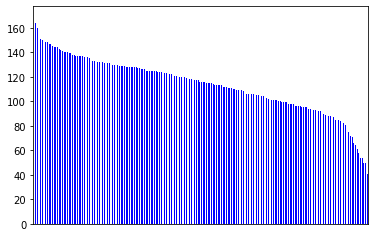

In [12]:
df_new.subject_str.value_counts().plot(kind='bar', color='b')
plt.xticks([])
plt.show()

In [13]:
df = df_new

In [14]:
len(np.unique(df.subject_number.tolist())), len(df)

(200, 22765)

In [15]:
from sklearn.utils import shuffle
np.random.seed(42)
df = shuffle(df)
df.reset_index(inplace=True)
df['utility']=df['subject_number']
df['secret']=df['gender_number']

df_train = df[:int(0.8*len(df))]
df_test = df[int(0.8*len(df)):int(0.9*len(df))]
df_val = df[int(0.9*len(df)):]

print('num train ; num test ; num val')
print(len(df_train),len(df_test),len(df_val))

img_size=(image_size, image_size, n_channels)
secret_list=['secret']
ns=2
utility_list=['utility']
nu=200
batch_size=64

#TODO! remove keras dependency with load_image wrapper
data_generator = BatchGeneratorFilterNew(df_train, training=True, batch_size=batch_size,
    secret_list=secret_list, utility_list=utility_list,
    output_list=['u','s'], input_list=["utility","secret"], img_size=img_size,
    shuffling=True, output_type='categorical', n_secrets=ns,n_utility=nu,)

data_generator_val = BatchGeneratorFilterNew(df_val, training=True, batch_size=batch_size,
    secret_list=secret_list, utility_list=utility_list,
    output_list=['u','s'], input_list=["utility","secret"], img_size=img_size,
    shuffling=True, output_type='categorical', n_secrets=ns,n_utility=nu,)

data_generator_test = BatchGeneratorFilterNew(df_test, training=True, batch_size=batch_size,
    secret_list=secret_list, utility_list=utility_list,
    output_list=['u','s'], input_list=["utility","secret"], img_size=img_size,
    shuffling=True, output_type='categorical', n_secrets=ns,n_utility=nu,)


# Get empirical Marginals and joint u,s distributions from labels
Pus, Pu,Ps = get_data_marginals(df_train,nu,ns)
Pus_test,Pu_test,Ps_test = get_data_marginals(df_test, nu,ns)
Pus_val,Pu_val,Ps_val = get_data_marginals(df_val, nu,ns)

print(' Prior S : ',Ps)

num train ; num test ; num val
18212 2276 2277
 Prior S :  [0.57906875 0.42093125]


# start of code
#### Placeholders + outputs + vars

In [16]:
tf.disable_eager_execution()

In [17]:
tf.reset_default_graph()

#####
#define all the placeholders for input and output variables
#####
input_image = tf.placeholder(tf.float32,  shape = (None, image_size, image_size, n_channels), name = 'input_image')
utility_gt_ph =  tf.placeholder(tf.float32,  shape = (None, nu), name = 'utility_gt_ph')
secret_gt_ph =  tf.placeholder(tf.float32,  shape = (None, ns), name = 'secret_gt_ph')
secret_prior_ph =  tf.placeholder(tf.float32,  shape = (None, ns), name = 'secret_prior_ph')

#####
# loss-related placeholders
#####
budget_ph =  tf.placeholder(tf.float32,  shape = (), name = 'budget')
lambda_ph =  tf.placeholder(tf.float32,  shape = (), name = 'lambda')
lr_u_ph = tf.placeholder(tf.float32,  shape = (), name = 'lr_u_ph')
lr_u_raw_ph = tf.placeholder(tf.float32,  shape = (), name = 'lr_u_raw_ph')
lr_s_ph = tf.placeholder(tf.float32,  shape = (), name = 'lr_s_ph')
lr_f_ph = tf.placeholder(tf.float32,  shape = (), name = 'lr_f_ph')
lr_c_ph = tf.placeholder(tf.float32,  shape = (), name = 'lr_c_ph')

#####
# Define outputs (separate by batchnorm behaviour)
#####
filter_outputs = filter_model(input_image, is_training=True, use_bn=use_batchnorm_filter)
secret_output_tr = secret_model(input_image, is_training=True,ns=ns, use_bn=use_batchnorm_classifiers)
utility_output_tr = utility_model(input_image, is_training=True,nu=nu, use_bn=use_batchnorm_classifiers)

update_ops_util = tf.get_collection(tf.GraphKeys.UPDATE_OPS, "utility/")
update_ops_util_raw = tf.get_collection(tf.GraphKeys.UPDATE_OPS, "utility_raw/")
update_ops_secret = tf.get_collection(tf.GraphKeys.UPDATE_OPS, "secret/")
update_ops_filter = tf.get_collection(tf.GraphKeys.UPDATE_OPS, "filter/")

utility_raw_output_tr  = utility_raw_model(input_image, is_training=True,nu=nu, use_bn=use_batchnorm_classifiers)
secret_output = secret_model(input_image, is_training=False, reuse=True,ns=ns, use_bn=use_batchnorm_classifiers)
utility_output = utility_model(input_image, is_training=False, reuse=True,nu=nu, use_bn=use_batchnorm_classifiers)
utility_raw_output  = utility_raw_model(input_image, is_training=False, reuse=True,nu=nu, use_bn=use_batchnorm_classifiers)
combined_outputs_tr = combined_model(input_image, is_training=True,nu=nu,ns=ns,
                                     use_bn_c=use_batchnorm_classifiers, use_bn_f=use_batchnorm_filter)

#####
#Get trainable variables
#####
utility_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "utility/")
utility_raw_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "utility_raw/")
secret_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "secret/")
filter_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "filter/")
secret_onlydense_vars=secret_vars[-2:]
utility_vars_denseonly=utility_vars[-2:]
utility_vars_nodense = utility_vars[:-2]

#####
#Create saver objects
#####
utility_saver = tf.train.Saver(utility_vars,max_to_keep=None)
utility_nodense_saver = tf.train.Saver(utility_vars_nodense,max_to_keep=None)
utility_raw_saver = tf.train.Saver(utility_raw_vars,max_to_keep=None)
secret_saver = tf.train.Saver(secret_vars,max_to_keep=None)
filter_saver = tf.train.Saver(filter_vars,max_to_keep=None)

#####
# Create mirror operation from utility_filter to utility_raw, utility_raw only mirrors pretraining on natural images
#####
mirror_ops=[] #Mirror operation to copy weights from utility_filter to utility_raw, only used for initialization after pretraining
for i in np.arange(len(utility_vars)):
    mirror_ops+=[tf.assign(utility_raw_vars[i],utility_vars[i])]

print('num param filter : ',count_parameters(filter_vars))
print('num param utility : ',count_parameters(utility_vars))
print('num param secret : ',count_parameters(secret_vars))

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Use `tf.keras.layers.SeparableConv2D` instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Use keras.layers.Dense instead.
num param filter :  2260193
num param utility :  3501312
num param secret :  3356970


# Set up loss functions and optimizers

In [18]:
# dKL losses for utility and secret networks, meant to train against ground truth
utility_loss = CE_loss(utility_gt_ph, utility_output_tr)
utility_raw_loss= CE_loss(utility_gt_ph, utility_raw_output_tr)
secret_loss = CE_loss(secret_gt_ph, secret_output_tr)

# Accuracy
utility_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(utility_output_tr,1),tf.argmax(utility_gt_ph,1)), tf.float32))
utility_raw_acc =  tf.reduce_mean(tf.cast(tf.equal(tf.argmax(utility_raw_output_tr,1),tf.argmax(utility_gt_ph,1)), tf.float32))
secret_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(secret_output_tr,1),tf.argmax(secret_gt_ph,1)), tf.float32))

# MSE loss for filter network, meant to train filter to copy image
filter_loss = tf.losses.mean_squared_error(input_image,filter_outputs)

# Combined loss desglosada en terminos de utlity y secret loss, 
(combined_loss,
 utility_combined_loss,
 secret_combined_loss) = eigan_loss(utility_gt_ph,secret_prior_ph, combined_outputs_tr)

In [19]:
# Solvers for all losses
with tf.control_dependencies(update_ops_util): #  needed to make sure batch_norm moving averages get updated!
    utility_optimizer = tf.train.AdamOptimizer(learning_rate=lr_u_ph)
    utility_denseonly_solver = utility_optimizer.minimize(utility_loss, var_list=utility_vars_denseonly)
    utility_solver = utility_optimizer.minimize(utility_loss, var_list=utility_vars)

with tf.control_dependencies(update_ops_util_raw): #  needed to make sure batch_norm moving averages get updated! 
    utility_raw_optimizer = tf.train.AdamOptimizer(learning_rate=lr_u_raw_ph)
    utility_raw_solver = utility_raw_optimizer.minimize(utility_raw_loss, var_list=utility_raw_vars)
    
with tf.control_dependencies(update_ops_secret): #  needed to make sure batch_norm moving averages get updated!
    secret_optimizer = tf.train.AdamOptimizer(learning_rate=lr_s_ph)
    secret_solver = secret_optimizer.minimize(secret_loss, var_list=secret_vars)
    secret_onlydense_optimizer = tf.train.AdamOptimizer(learning_rate=lr_s_ph)
    secret_onlydense_solver = secret_onlydense_optimizer.minimize(secret_loss, var_list=secret_onlydense_vars)

with tf.control_dependencies(update_ops_filter): #  needed to make sure batch_norm moving averages get updated!
    filter_optimizer = tf.train.AdamOptimizer(learning_rate=lr_f_ph)
    combined_optimizer = tf.train.AdamOptimizer(learning_rate=lr_c_ph)
    filter_solver = filter_optimizer.minimize(filter_loss, var_list=filter_vars)
    combined_solver = combined_optimizer.minimize(combined_loss, var_list=filter_vars)

# Summaries

In [20]:
scalar_summaries={}
# Loss and accuracy summaries for utility and secret
scalar_summaries['utility_raw_acc_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'utility_raw_acc_ph')
scalar_summaries['utility_raw_acc'] = tf.summary.scalar(
    "utility_raw_accuracy", scalar_summaries['utility_raw_acc_ph'])
scalar_summaries['utility_acc_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'utility_acc_ph')
scalar_summaries['utility_acc'] = tf.summary.scalar(
    "utility_accuracy", scalar_summaries['utility_acc_ph'])
scalar_summaries['utility_raw_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'utility_raw_loss_ph')
scalar_summaries['utility_raw_loss'] = tf.summary.scalar(
    "utility_raw_loss", scalar_summaries['utility_raw_loss_ph'])
scalar_summaries['utility_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'utility_loss_ph')
scalar_summaries['utility_loss'] = tf.summary.scalar(
    "utility_loss", scalar_summaries['utility_loss_ph'])
scalar_summaries['secret_acc_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'secret_acc_ph')
scalar_summaries['secret_acc'] = tf.summary.scalar(
    "secret_accuracy", scalar_summaries['secret_acc_ph'])
scalar_summaries['secret_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'secret_loss_ph')
scalar_summaries['secret_loss'] = tf.summary.scalar(
    "secret_loss", scalar_summaries['secret_loss_ph'])
# loss summaries for filter
scalar_summaries['filter_mse_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'filter_mse_loss_ph')
scalar_summaries['filter_mse_loss'] = tf.summary.scalar(
    "mse_reconstruction_loss", scalar_summaries['filter_mse_loss_ph'])

scalar_summaries['filter_CIB_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'filter_CIB_loss_ph')
scalar_summaries['filter_CIB_loss'] = tf.summary.scalar(
    "CIB_loss", scalar_summaries['filter_CIB_loss_ph'])

scalar_summaries['filter_censored_info_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'filter_censored_info_loss_ph')
scalar_summaries['filter_censored_info_loss'] = tf.summary.scalar(
    "Censored_information_loss", scalar_summaries['filter_censored_info_loss_ph'])

scalar_summaries['filter_information_penalty_loss_ph'] = tf.placeholder(
    tf.float32,  shape = (), name = 'filter_information_penalty_loss_ph')
scalar_summaries['filter_information_penalty_loss'] = tf.summary.scalar(
    "Information_penalty_loss", scalar_summaries['filter_information_penalty_loss_ph'])

scalar_summaries['merged_training_losses']= tf.summary.merge(
    [scalar_summaries['utility_acc'],scalar_summaries['utility_loss'],
     scalar_summaries['utility_raw_acc'],scalar_summaries['utility_raw_loss'],
     scalar_summaries['secret_acc'],scalar_summaries['secret_loss'],
     scalar_summaries['filter_CIB_loss'],scalar_summaries['filter_censored_info_loss'],
     scalar_summaries['filter_information_penalty_loss']])


image_summaries={}
image_summaries["real_image"] = tf.summary.image("real_image", input_image, max_outputs=20)
image_summaries["filtered_image"] = tf.summary.image("filtered_image", filter_outputs, max_outputs=20)
image_summaries['merged_image_summary']= tf.summary.merge([image_summaries["real_image"], image_summaries["filtered_image"] ])


# START OF TRAINING


# Initialize session

In [21]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess= tf.Session(config=config)
init = tf.global_variables_initializer()
sess.run(init)

In [22]:
logdir = './logs/{:s}_BN_filter_{:}_BN_classifier_{:}/'.format(model_name, use_batchnorm_filter, use_batchnorm_classifiers)
writer = tf.summary.FileWriter(logdir+"pretrain")
val_writer = tf.summary.FileWriter(logdir+"pretrain")

# Reload and/or train classifier networks

In [23]:
if load_pretrained_classifiers:
    named_path = os.path.join(pretrain_checkpoint_dir, model_name)
    classifier_type_path = 'batch_norm' if use_batchnorm_classifiers else 'instance_norm'
    named_class_path = os.path.join(named_path, classifier_type_path)
    pretrain_checkpoint_dir_ur = os.path.join(named_class_path, 'utility_raw')
    pretrain_checkpoint_dir_uf = os.path.join(named_class_path, 'utility_filtered')
    pretrain_checkpoint_dir_s = os.path.join(named_class_path, 'secret')


    ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_uf)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        utility_saver.restore(sess, os.path.join(pretrain_checkpoint_dir_uf, ckpt_name))
        ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_uf)
    ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_ur)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        utility_raw_saver.restore(sess, os.path.join(pretrain_checkpoint_dir_ur, ckpt_name))
    ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_s)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        secret_saver.restore(sess, os.path.join(pretrain_checkpoint_dir_s, ckpt_name))

In [24]:
from tqdm import tqdm

In [25]:
len(data_generator)

285

In [26]:
if pretrain_classifiers:
    
    n_epochs=50
    n_batches = len(data_generator)


    u_loss_array=np.zeros(n_epochs*n_batches)
    u_acc_array=np.zeros(n_epochs*n_batches)
    s_loss_array=np.zeros(n_epochs*n_batches)
    s_acc_array=np.zeros(n_epochs*n_batches)


    it = -1
    for epoch in range(n_epochs):
        print(epoch)
        data_generator.shuffle()
        for idx in tqdm(np.arange(n_batches), leave=False):
            it+=1

            data_batch = data_generator.__getitem__(idx)
            imgs = data_batch[0][0]
            utility_gt = data_batch[1][0]  
            secret_gt = data_batch[1][1]

            (_,_,
             utility_loss_curr, secret_loss_curr,
             pred_u, pred_s)= sess.run(
                [utility_solver, secret_solver,utility_loss,secret_loss,utility_output, secret_output,
                ], 
                feed_dict={input_image: imgs, utility_gt_ph: utility_gt, secret_gt_ph: secret_gt,
                lr_u_ph: 1e-4, lr_s_ph: 1e-4})            
            
            s_loss_array[it]=secret_loss_curr
            s_acc_array[it]=np.mean(np.argmax(pred_s,1)==secret_gt.argmax(1))

            u_loss_array[it]=utility_loss_curr
            u_acc_array[it]=np.mean(np.argmax(pred_u,1)==utility_gt.argmax(1))


            feed_dict={
                scalar_summaries['utility_acc_ph']: u_acc_array[it],
                scalar_summaries['utility_loss_ph']: u_loss_array[it],
                scalar_summaries['secret_acc_ph']: s_acc_array[it],
                scalar_summaries['secret_loss_ph']: s_loss_array[it],
            }

            scalar_sum_1, scalar_sum_2, scalar_sum_3, scalar_sum_4  = sess.run(
                [scalar_summaries['utility_acc'],
                scalar_summaries['utility_loss'],
                scalar_summaries['secret_acc'],
                scalar_summaries['secret_loss'],],
                feed_dict=feed_dict
            )
            writer.add_summary(scalar_sum_1, it)
            writer.add_summary(scalar_sum_2, it)
            writer.add_summary(scalar_sum_3, it)
            writer.add_summary(scalar_sum_4, it)


            if it %1000 ==999:
                named_path = os.path.join(pretrain_checkpoint_dir, model_name)

                classifier_type_path = 'batch_norm' if use_batchnorm_classifiers else 'instance_norm'
                named_class_path = os.path.join(named_path, classifier_type_path)

                pretrain_checkpoint_dir_ur = os.path.join(named_class_path, 'utility_raw')
                pretrain_checkpoint_dir_uf = os.path.join(named_class_path, 'utility_filtered')
                pretrain_checkpoint_dir_s = os.path.join(named_class_path, 'secret')

                if not os.path.exists(pretrain_checkpoint_dir):
                    os.makedirs(pretrain_checkpoint_dir)
                if not os.path.exists(named_path):
                    os.makedirs(named_path)
                if not os.path.exists(named_class_path):
                    os.makedirs(named_class_path)
                if not os.path.exists(pretrain_checkpoint_dir_ur):
                    os.makedirs(pretrain_checkpoint_dir_ur)
                if not os.path.exists(pretrain_checkpoint_dir_uf):
                    os.makedirs(pretrain_checkpoint_dir_uf)
                if not os.path.exists(pretrain_checkpoint_dir_s):
                    os.makedirs(pretrain_checkpoint_dir_s)


                sess.run(mirror_ops)
                utility_saver.save(sess, os.path.join(pretrain_checkpoint_dir_uf,'utility_filtered'), global_step=it)
                secret_saver.save(sess, os.path.join(pretrain_checkpoint_dir_s,'secret'), global_step=it)
                utility_raw_saver.save(sess,os.path.join(pretrain_checkpoint_dir_ur,'utility_raw'), global_step=it)

  0%|          | 0/285 [00:00<?, ?it/s]

0


  0%|          | 0/285 [00:00<?, ?it/s]          

1


  0%|          | 0/285 [00:00<?, ?it/s]          

2


  0%|          | 0/285 [00:00<?, ?it/s]          

3


 51%|█████     | 144/285 [01:11<01:12,  1.95it/s]

INFO:tensorflow:basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/utility_filtered/utility_filtered-999 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/secret/secret-999 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/utility_raw/utility_raw-999 is not in all_model_checkpoint_paths. Manually adding it.


  0%|          | 0/285 [00:00<?, ?it/s]          

4


  0%|          | 0/285 [00:00<?, ?it/s]          

5


 35%|███▌      | 100/285 [00:49<01:31,  2.03it/s]

KeyboardInterrupt: 

In [27]:
input_image

<tf.Tensor 'input_image:0' shape=(None, 128, 128, 1) dtype=float32>

In [28]:
data_generator_test.filepath

['/data/FaceScrub/Jennette_McCurdy/face/fba9e40d62c610f13d1fe4b8b12d889c454d10da.jpg',
 '/data/FaceScrub/Chris_Klein/face/f23f5590d6d5da1c614c241b747c0e8ad450c63e.jpg',
 '/data/FaceScrub/Marcia_Cross/face/8f80805c598ee232a5bad32b353e8016f02e7c4d.jpg',
 '/data/FaceScrub/Charlie_Sheen/face/d0fde0295735b7c19873a2e047187802875ff20b.jpg',
 '/data/FaceScrub/Holly_Marie_Combs/face/e6802f1bec5aacd4449ce7ac103d34e3f976e1df.jpg',
 '/data/FaceScrub/Charlie_Sheen/face/54fb0bd473d55e1b0e41f5910c06d9042177fa38.jpg',
 '/data/FaceScrub/Josh_Hartnett/face/9f23e091fed348e87e8bec21d5ae0482eeffa5e6.jpg',
 '/data/FaceScrub/Tamala_Jones/face/093dc54225a76dbf14816f83a55546d52d0a7b6d.jpg',
 '/data/FaceScrub/McKayla_Maroney/face/156e54ffd69cbd9d22652a301896d2393b86e3d8.jpg',
 '/data/FaceScrub/Lorraine_Bracco/face/57f80d1bcf7e7f08fc1536e86fa78b23d8a86fa1.jpg',
 '/data/FaceScrub/Josh_Brolin/face/f2eca7f2074581bae857306a6f0938cebd596e69.jpg',
 '/data/FaceScrub/Laurie_Metcalf/face/77eb413ed7921feca6a83fddc9d33ce41

In [29]:
pred_u,gt_u = pred_network(utility_output,input_image,200,data_generator_test,n_val=None,flag=0,sess=sess)
pred_s,gt_s = pred_network(secret_output,input_image,2,data_generator_test,n_val=None,flag=1,sess=sess)

In [30]:
!ls /data

ATTFaces   ISBI   NICO		    Titanic		 faceScrub.zip
CelebA	   MIMIC  NetflixPrizeData  Waymo
FaceScrub  MNIST  SVNH		    cifar-10-batches-py


In [31]:
print('Raw Test acc u top 5:' ,get_categorical_performance(pred_u,gt_u,ntop = 5))
print('Raw Test acc s:' ,get_categorical_performance(pred_s,gt_s,ntop = 1))

Raw Test acc u top 5: 0.45738137082601055
Raw Test acc s: 0.9753954305799648


# Reload and/or train Filter with MSE loss

In [32]:
if load_pretrained_filter:
    named_path = os.path.join(pretrain_checkpoint_dir, model_name)
    filter_type_path = 'batch_norm' if use_batchnorm_filter else 'instance_norm'
    named_filter_path = os.path.join(named_path, filter_type_path)
    pretrain_checkpoint_dir_f = os.path.join(named_filter_path, 'filter')


    ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_f)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        filter_saver.restore(sess, os.path.join(pretrain_checkpoint_dir_f, ckpt_name))

In [33]:
if pretrain_filter:
    n_epochs=1
    n_batches = len(data_generator)

    filter_loss_array = np.zeros(n_epochs*n_batches)

    it = -1
    for epoch in range(n_epochs):
        data_generator.shuffle()
        for idx in tqdm(np.arange(n_batches), leave=False):
            it+=1

            data_batch = data_generator.__getitem__(idx)
            imgs = data_batch[0][0]
            utility_gt = data_batch[1][0]  
            secret_gt = data_batch[1][1]


            _, filter_loss_curr, = sess.run([filter_solver, filter_loss ], 
                                            feed_dict={input_image: imgs, lr_f_ph: 1e-2})
            filter_loss_array[it]=filter_loss_curr


            scalar_sum = sess.run(
                scalar_summaries['filter_mse_loss'], 
                feed_dict={scalar_summaries['filter_mse_loss_ph']:filter_loss_curr}
            )
            writer.add_summary(scalar_sum, it)
            if it%50==0:
                image_sum = sess.run(
                    image_summaries['merged_image_summary'], 
                    feed_dict={input_image: imgs}
                )
            writer.add_summary(image_sum, it)

            if it %1000 ==999:
                named_path = os.path.join(pretrain_checkpoint_dir, model_name)

                filter_type_path = 'batch_norm' if use_batchnorm_filter else 'instance_norm'
                named_filter_path = os.path.join(named_path, filter_type_path)
                pretrain_checkpoint_dir_f = os.path.join(named_filter_path, 'filter')



                if not os.path.exists(pretrain_checkpoint_dir):
                    os.makedirs(pretrain_checkpoint_dir)
                if not os.path.exists(named_path):
                    os.makedirs(named_path)
                if not os.path.exists(named_filter_path):
                    os.makedirs(named_filter_path)
                if not os.path.exists(pretrain_checkpoint_dir_f):
                    os.makedirs(pretrain_checkpoint_dir_f)
                filter_saver.save(sess, os.path.join(pretrain_checkpoint_dir_f,'filter'), global_step=it)

# Define and/or load combined model

In [34]:
opt_vars = utility_optimizer.variables()
opt_vars += utility_raw_optimizer.variables()
opt_vars += secret_optimizer.variables()
opt_vars += filter_optimizer.variables()
opt_vars += combined_optimizer.variables()

reset_optimizer_op = tf.variables_initializer(opt_vars)

In [35]:
from AdversarialIOPenalty import AIOIGAN

budget_array = np.array([0.5,0.4,0.3,0.2,0.1,0.001])

# Initialize ganClass
ganClass = AIOIGAN(data_generator,
        utility_output, utility_loss, utility_acc, utility_denseonly_solver,
        utility_raw_output, utility_raw_loss, utility_raw_acc, utility_raw_solver,
        secret_output, secret_loss, secret_acc, secret_solver,
        filter_outputs, filter_loss, filter_solver,
        combined_loss, utility_combined_loss, secret_combined_loss, combined_solver,
        budget_ph, lambda_ph, lr_u_ph, lr_u_ph, lr_s_ph, lr_f_ph, lr_c_ph,
        input_image, input_image, utility_gt_ph, secret_gt_ph, secret_prior_ph,
        utility_saver, utility_raw_saver, secret_saver, filter_saver,
        sess,lambda_val=5e1,budget_val = budget_array[0],
        n_f=1,n_s=1,n_u=0,
        lr_u=5e-4,lr_s=5e-4,lr_f=1e-4,lr_c=5e-4, lr_u_r =1e-4, 
        dg_val = data_generator_val,
        Sprior = Ps,Uprior = Pu, 
        model_name=model_name,
        checkpoint_dir=train_checkpoint_dir,
        pretrain_checkpoint_dir=pretrain_checkpoint_dir,
        scalar_summary=scalar_summaries, image_summary=image_summaries,
        use_batchnorm_classifiers=use_batchnorm_classifiers,
        use_batchnorm_filter = use_batchnorm_filter
    )

In [33]:
#Load a model for a budget previously trained (can comment)
ix_k = 3  #(only one uploaded to git, others will be uploaded to dropbox)
# budget_load = budget_array[ix_k]
# print('######## BUDGET '+str(budget_load))
# print('   ')

# #load budget
# ganClass.load(ganClass.checkpoint_dir,ganClass.pretrain_checkpoint_dir,
#                       load_type='train',budget_val=budget_load)
# ganClass.budget_val = budget_load

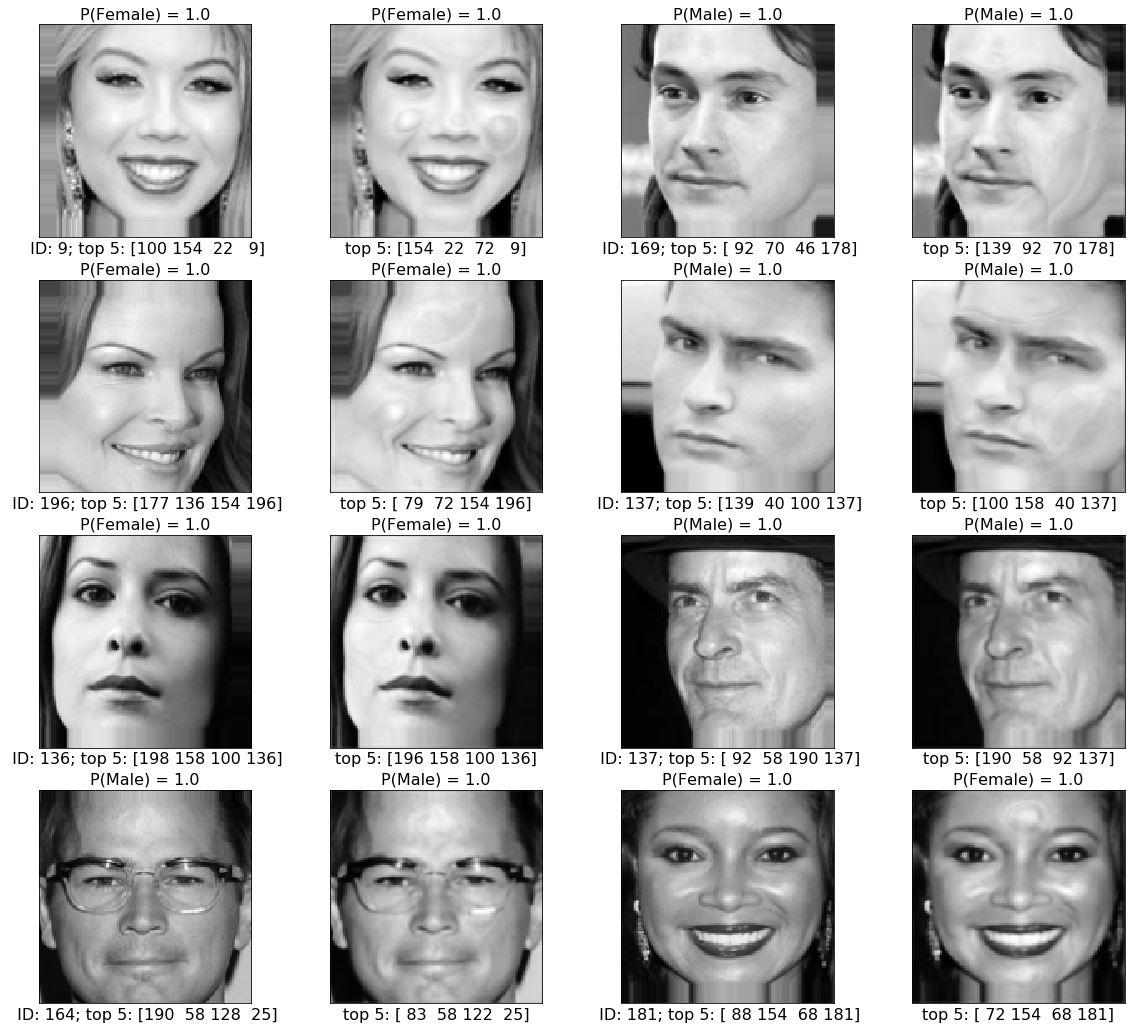

In [36]:
# Visualize some test images
n_it = 1
for idx in np.arange(n_it):
    
    # Get data batch
    data_batch = data_generator_test.__getitem__(idx)
    imgs = data_batch[0][0]
    utility_gt_idx = data_batch[1][0]
    secret_gt_idx = data_batch[1][1]

    # Evaluate raw image
    pUX_aux,pSX_aux = sess.run([ganClass.utility_output, ganClass.secret_output],
                                 feed_dict={ganClass.raw_input_image_ph:imgs}) 
    
    # Get filtered images & evaluate
    gen_imgs = sess.run(ganClass.filter_output, feed_dict={ganClass.input_image_ph: imgs})
    pUY_aux, pSY_aux = sess.run([ganClass.utility_output, ganClass.secret_output],
                                 feed_dict={ganClass.raw_input_image_ph:gen_imgs})

    u_gt = np.argmax(utility_gt_idx[:,:],axis = 1)
    s_gt = np.argmax(secret_gt_idx[:,:],axis = 1)
    
    plt.figure(figsize=(20,18))
    ix_p = 1
    for i in np.arange(8):
        u_top5 = np.argsort(pUY_aux[i,:])[-4:]
        u_top5gt = np.argsort(pUX_aux[i,:])[-4:]

        if s_gt[i] == 0:
            title_str = 'P(Male) = '+str(np.round(pSY_aux[i,s_gt[i]],2))
            title_str_o = 'P(Male) = '+str(np.round(pSX_aux[i,s_gt[i]],2))
        else:
            title_str = 'P(Female) = '+str(np.round(pSY_aux[i,s_gt[i]],2))
            title_str_o = 'P(Female) = '+str(np.round(pSX_aux[i,s_gt[i]],2))

        
        plt.subplot(4,4,ix_p)
        ix_p += 1
        plt.title(title_str_o,fontsize = 16)
        plt.imshow(imgs[i,:,:,:].squeeze(),cmap = 'gray')
        plt.xlabel(' ID: '+str(u_gt[i]) + '; top 5: '+str(u_top5gt),fontsize = 16)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4,4,ix_p)
        ix_p += 1
        plt.title(title_str,fontsize = 16)
        plt.imshow(gen_imgs[i,:,:,:].squeeze(),cmap = 'gray')
        plt.xlabel( 'top 5: '+str(u_top5),fontsize = 16)
        plt.yticks([])
        plt.xticks([])
    plt.show()

### Training cell (uncomment)

In [37]:
budget_array = np.array([0.5,0.4,0.3,0.2,0.1,0.001])

In [38]:
# Skip false to train#

skip = False

if not skip:
    
    for budget in budget_array[:1]:
        print('-'*80)
        print(budget)
        print('-'*80)
        sess.run(reset_optimizer_op)

        #set budget
        ganClass.budget_val = budget

        ganClass.train(60, sample_interval=100, eval_interval=50, save_image=True)
        save_everything(ganClass,dg = data_generator_test, nu=nu,ns=ns,
                        savepath= 'checkpoint_eigan/budget_{:.2e}_summary_NM_unet_inorm_aux.pkl'.format(budget))

--------------------------------------------------------------------------------
0.5
--------------------------------------------------------------------------------
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/bat

INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/ins

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
s

# Train Dense layer of utility for each budget

In [39]:
ganClass.checkpoint_dir, ganClass.pretrain_checkpoint_dir

('checkpoint_eigan', 'basecheckpoint_eigan')

In [41]:
n_epochs=20

In [42]:
#Skip false to train#
skip = False

if not skip:
    
    epochs_array = np.ones(budget_array.shape, dtype=int)*20

    n_batches = len(data_generator)
    s_loss_array=np.zeros(n_epochs*n_batches)
    s_acc_array=np.zeros(n_epochs*n_batches)

    u_loss_dic = {}
    u_acc_dic = {}
    u_pred_dic = {}
    u_gt_dic = {}


    save_data = {}
    for k in np.arange(budget_array[:1].shape[0]):
        print(k)
        n_epochs=epochs_array[k]
        budget_load = budget_array[k]

        ganClass.load(ganClass.checkpoint_dir,ganClass.pretrain_checkpoint_dir,
                          load_type='train',budget_val=budget_load)


        sess.run(reset_optimizer_op)
        it = -1
        u_loss_array=np.zeros(n_epochs*n_batches)
        u_acc_array=np.zeros(n_epochs*n_batches)
        for epoch in range(n_epochs):
            data_generator.shuffle()
            for idx in np.arange(n_batches):
                it+=1

                data_batch = data_generator.__getitem__(idx)
                imgs = data_batch[0][0]
                utility_gt = data_batch[1][0]  
                secret_gt = data_batch[1][1]

                 # Get filtered images
                gen_imgs = sess.run(ganClass.filter_output, feed_dict={ganClass.input_image_ph: imgs})

                (_,utility_loss_curr, pred_u)= sess.run(
                    [ utility_denseonly_solver,utility_loss, utility_output,
                    ], 
                    feed_dict={input_image: gen_imgs, utility_gt_ph: utility_gt, secret_gt_ph: secret_gt,
                        lr_u_ph: 1e-2, lr_s_ph: 1e-2})

                pUY_aux, pSY_aux = sess.run([ganClass.utility_output, ganClass.secret_output],
                                             feed_dict={ganClass.raw_input_image_ph:gen_imgs})

                u_loss_array[it]=utility_loss_curr
                u_acc_array[it]=np.mean(np.argmax(pred_u,1)==utility_gt.argmax(1))

        utility_saver.save(sess,'checkpoint/budget_{:.2e}_udensetrain_inorm_v0.pkl'.format(budget_load))

        pred_uf,gt_uf =  pred_ganclass_network(ganClass,nu,data_generator_test,filtro = True, n_val=None,flag=0)
        print('filtered Test acc u top 5:' ,get_categorical_performance(pred_uf,gt_uf,ntop = 5))

        u_pred_dic[k] = pred_uf
        u_gt_dic[k] = gt_uf
        u_loss_dic[k] = u_loss_array[0:it]
        u_acc_dic[k] = u_acc_array[0:it]

        save_data['u_pred_dic'] = u_pred_dic
        save_data['u_gt_dic'] = u_gt_dic
        save_data['u_loss_dic'] = u_loss_dic
        save_data['u_acc_dic'] = u_acc_dic
        savepath = 'checkpoint/budget_{:.2e}_summary_densetrain.pkl'.format(budget_load)
        import pickle
        with open(savepath, 'wb') as f:
            pickle.dump(save_data, f)

0
 [*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/utility_raw/utility_raw-13999
Utility Raw restore success
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1
Utility Filtered restore success
checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1
Secret restore success
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1
Filter restore success
INFO:tensorflow:checkpoint/budget_5.00e-01_udensetrain_inorm_v0.pkl is not in all_model_checkpoint_paths. Manually adding it.
filtered Test acc u top 5: 0.476713532513181


# Save Performance for analisis


In [44]:
ix_k=0

In [43]:
epochs_array

array([20, 20, 20, 20, 20, 20])

In [45]:
table_dic = {}
table_labels = ['ix','budget','subject','gender','acc_u(x)','acc_u(y)','acc_ud(y)',
               'conf_u(x)','conf_u(y)','conf_ud(y)','acc_s(x)','acc_s(y)','acc_so(y)',
               'conf_s(x)','conf_s(y)','conf_so(y)','dkl_ux_pu','dkl_udy_pu','dkl_ux_udy',
               'dkl_ux_uy','dkl_sx_ps','dkl_sy_ps','dkl_soy_ps']

Pus_test,Pu_test,Ps_test = get_data_marginals(df_test, nu,ns)

# Change the for to iterate over all budget_array if models have been trained !!!!!:::

# for k in np.arange(budget_array.shape[0]):
for k in np.array([ix_k]):
    budget_load = budget_array[k]
    
    print('######## BUDGET '+str(budget_load))
    print('   ')
    
    #load budget
    ganClass.load(ganClass.checkpoint_dir,ganClass.pretrain_checkpoint_dir,
                          load_type='train',budget_val=budget_load)
    ganClass.budget_val = budget_load
    
    pred_u,gt_u = pred_ganclass_network(ganClass,nu,data_generator_test,filtro = False, n_val=None,flag=0)
    pred_uy,gt_uy = pred_ganclass_network(ganClass,nu,data_generator_test,filtro = True, n_val=None,flag=0)
    pred_sy,gt_sy = pred_ganclass_network(ganClass,ns,data_generator_test,filtro = True, n_val=None,flag=1)

    #load dense utility and evaluate
    utility_saver.restore(sess, 'checkpoint/budget_{:.2e}_udensetrain_inorm_v0.pkl'.format(budget_load))
    pred_uyd,gt_uyd = pred_ganclass_network(ganClass,nu,data_generator_test,filtro = True, n_val=None,flag=0)

    #load original secret (trained on original images) and evaluate
    named_path = os.path.join(pretrain_checkpoint_dir, model_name)
    classifier_type_path = 'batch_norm' if use_batchnorm_classifiers else 'instance_norm'
    named_class_path = os.path.join(named_path, classifier_type_path)
    pretrain_checkpoint_dir_s = os.path.join(named_class_path, 'secret')
    ckpt = tf.train.get_checkpoint_state(pretrain_checkpoint_dir_s)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        secret_saver.restore(sess, os.path.join(pretrain_checkpoint_dir_s, ckpt_name))

    pred_s,gt_s = pred_ganclass_network(ganClass,ns,data_generator_test,filtro = False, n_val=None,flag=1)
    pred_syo,gt_syo = pred_ganclass_network(ganClass,ns,data_generator_test,filtro = True, n_val=None,flag=1)
    

    ### SAVE TABLES ###
    table_array = np.zeros([gt_s.shape[0],23])

    #index test,budget, subject, gender
    table_array[:,0] = np.arange(gt_s.shape[0])
    table_array[:,1] = budget_load
    table_array[:,2] = np.argmax(gt_u,axis = 1)
    table_array[:,3] = np.argmax(gt_s,axis = 1)

    #u(x); u(y); u_dense(y)

    #top 5 accuracy
    for i in np.arange(gt_s.shape[0]):
        table_array[i,4] = get_categorical_performance(pred_u[i,:][np.newaxis,:],gt_u[i,:][np.newaxis,:],ntop = 5)
        table_array[i,5] = get_categorical_performance(pred_uy[i,:][np.newaxis,:],gt_u[i,:][np.newaxis,:],ntop = 5)
        table_array[i,6] = get_categorical_performance(pred_uyd[i,:][np.newaxis,:],gt_u[i,:][np.newaxis,:],ntop = 5)

        #confidence in true label
        table_array[i,7] = pred_u[i,np.argmax(gt_u[i,:])]
        table_array[i,8] = pred_uy[i,np.argmax(gt_u[i,:])]
        table_array[i,9] = pred_uyd[i,np.argmax(gt_u[i,:])]

        #s(x); s(y); s_dense(y)

        #confidence in true label
        table_array[i,13] = pred_s[i,np.argmax(gt_s[i,:])]
        table_array[i,14] = pred_sy[i,np.argmax(gt_s[i,:])]
        table_array[i,15] = pred_syo[i,np.argmax(gt_s[i,:])]

    #top 1 accuracy
    table_array[:,10] = (np.argmax(pred_s,axis = 1) ==  np.argmax(gt_s,axis = 1)).astype('int')
    table_array[:,11] = (np.argmax(pred_sy,axis = 1) ==  np.argmax(gt_s,axis = 1)).astype('int')
    table_array[:,12] = (np.argmax(pred_syo,axis = 1) ==  np.argmax(gt_s,axis = 1)).astype('int')

    #DKLs pUX||pUY_ud
    prior_u = Pu_test[np.newaxis,:]
    table_array[:,16] = np.sum(pred_u*(np.log(np.maximum(pred_u,1e-7))-np.log(np.maximum(prior_u,1e-7))),axis = 1)
    table_array[:,17] = np.sum(pred_uyd*(np.log(np.maximum(pred_uyd,1e-7))-np.log(np.maximum(prior_u,1e-7))),axis = 1)
    table_array[:,18] = np.sum(pred_u*(np.log(np.maximum(pred_u,1e-7))-np.log(np.maximum(pred_uyd,1e-7))),axis = 1)
    table_array[:,19] = np.sum(pred_u*(np.log(np.maximum(pred_u,1e-7))-np.log(np.maximum(pred_uy,1e-7))),axis = 1)
    prior_s = Ps_test[np.newaxis,:]
    table_array[:,20] = np.sum(pred_s*(np.log(np.maximum(pred_s,1e-7))-np.log(np.maximum(prior_s,1e-7))),axis = 1)
    table_array[:,21] = np.sum(pred_sy*(np.log(np.maximum(pred_sy,1e-7))-np.log(np.maximum(prior_s,1e-7))),axis = 1)
    table_array[:,22] = np.sum(pred_syo*(np.log(np.maximum(pred_syo,1e-7))-np.log(np.maximum(prior_s,1e-7))),axis = 1)

    table_dic[k] = table_array
    save_data={}
    save_data['table_dic'] = table_dic
    save_data['table_labels'] = table_labels
    save_data['Pus_test'] = Pus_test
    save_data['Pu_test'] = Pu_test
    save_data['Ps_test'] = Ps_test
    savepath = 'checkpoint_eigan/summary_results_testset_SVG_NM_unet_icml.pkl'

    import pickle
    with open(savepath, 'wb') as f:
        pickle.dump(save_data, f)

######## BUDGET 0.5
   
 [*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/utility_raw/utility_raw-13999
Utility Raw restore success
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/utility_filtered/utility_filtered-1
Utility Filtered restore success
checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/batch_norm/secret/secret-1
Secret restore success
INFO:tensorflow:Restoring parameters from checkpoint_eigan/SubjectVsGender_EIGAN_0.50000/instance_norm/filter/filter-1
Filter restore success
INFO:tensorflow:Restoring parameters from checkpoint/budget_5.00e-01_udensetrain_inorm_v0.pkl
INFO:tensorflow:Restoring parameters from basecheckpoint_eigan/SubjectVsGender_EIGAN/batch_norm/secret/secret-13999


In [28]:
import pickle as pkl
save_data = pkl.load(open('checkpoint/summary_results_testset_SVG_NM_unet_icml_eigan.pkl', 'rb'))

# Report Performance

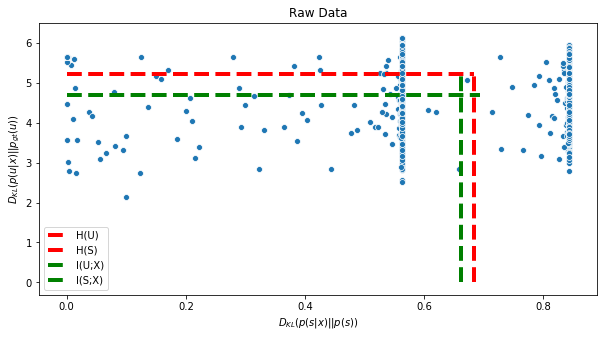

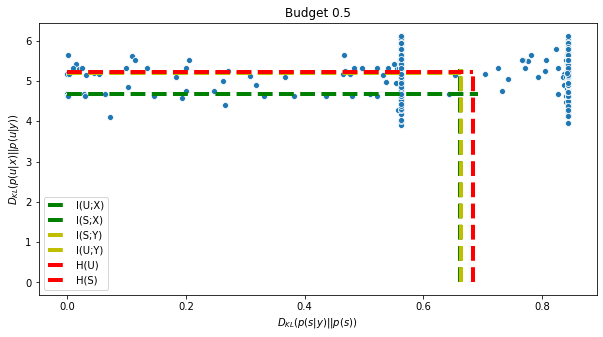

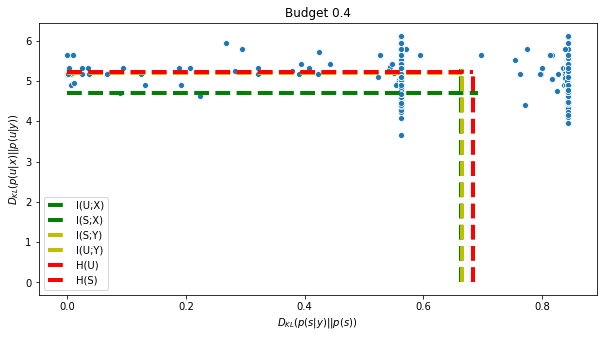

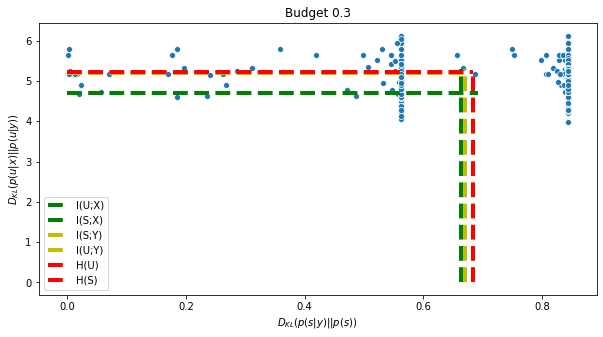

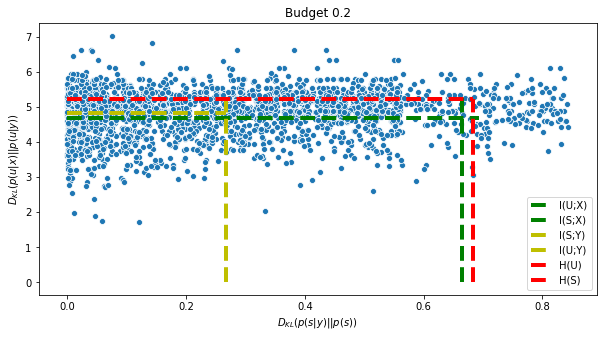

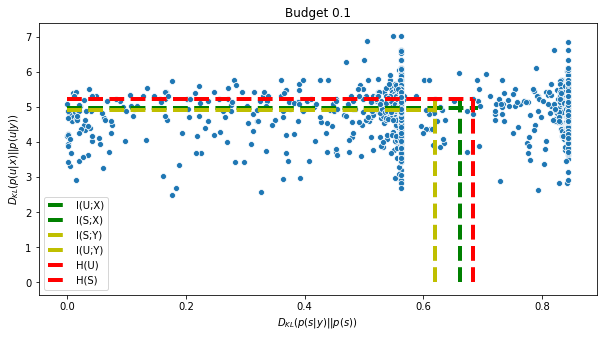

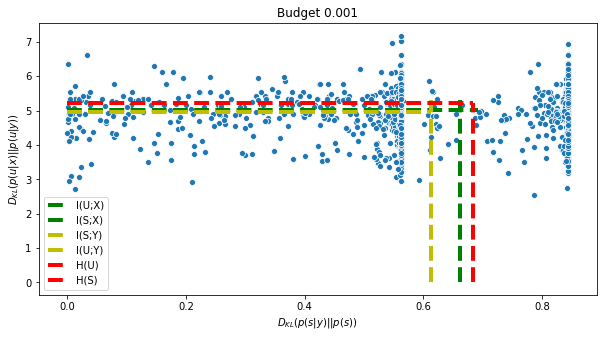

In [33]:
ix = 0
for k in save_data['table_dic'].keys():
    table_array = save_data['table_dic'][k]
    if ix == 0:
        table_cons = np.array(table_array)
    else:
        table_cons = np.concatenate([table_cons,table_array],axis = 0)
    ix += 1

df_data = pd.DataFrame(data=table_cons,columns=save_data['table_labels'])
df_data.columns

accuracy_table = np.zeros([df_data.budget.unique().shape[0]+1,5])
confidence_table = np.zeros([df_data.budget.unique().shape[0]+1,5])
MI_table = np.zeros([df_data.budget.unique().shape[0]+1,3])

# plot KL(p(x|s)||pS)) vs  KL(p(x|u)||p_u_gt)
plt.figure(figsize = (10,5))
plt.title('Raw Data')
hs = -1*np.sum(Ps_test*np.log(np.maximum(Ps_test,1e-7)))
hu = -1*np.sum(Pu_test*np.log(np.maximum(Pu_test,1e-7)))
plt.plot(np.array([0,hs]),np.array([hu,hu]),'r--',label = 'H(U)',linewidth = 4)
plt.plot(np.array([hs,hs]),np.array([0,hu]),'r--',label = 'H(S)',linewidth = 4)

ax = sns.scatterplot(x="dkl_sx_ps", y='dkl_ux_pu', data=df_data[df_data.budget == df_data.budget.unique()[0]] )
m_ux = df_data[df_data.budget == df_data.budget.unique()[0]].dkl_ux_pu.mean()
m_sx = df_data[df_data.budget == df_data.budget.unique()[0]].dkl_sx_ps.mean()
plt.plot(np.array([0,np.log(2)]),np.array([m_ux,m_ux]),'g--',label = 'I(U;X)',linewidth = 4)
plt.plot(np.array([m_sx,m_sx]),np.array([0,np.log(200)]),'g--',label = 'I(S;X)',linewidth = 4)
plt.xlabel(r'$D_{KL}(p(s|x)||p(s))$')
plt.ylabel(r'$D_{KL}(p(u|x)||p_{gt}(u))$')
plt.legend()
plt.show()

##save tables for k = np.inf (raw data)
accuracy_table[0,0] = np.inf
accuracy_table[0,1] = df_data['acc_u(x)'].mean()
accuracy_table[0,2] = df_data['acc_u(x)'].mean()
accuracy_table[0,3] = df_data['acc_s(x)'].mean()
accuracy_table[0,4] = df_data['acc_s(x)'].mean()

confidence_table[0,0] = np.inf
confidence_table[0,1] = df_data['conf_u(x)'].mean()
confidence_table[0,2] = df_data['conf_u(x)'].mean()
confidence_table[0,3] = df_data['conf_s(x)'].mean()
confidence_table[0,4] = df_data['conf_s(x)'].mean()

MI_table[0,0] = np.inf
MI_table[0,1] = 0
MI_table[0,2] = df_data['dkl_sx_ps'].mean()

cont= 1
for budget in df_data.budget.unique():

    # plot KL(p(y|s)||p(s)) vs  KL(p(x|u)||p(y|u))
    plt.figure(figsize = (10,5))
    plt.title('Budget '+str(budget))
    ax = sns.scatterplot(x="dkl_sy_ps", y='dkl_udy_pu', data=df_data[df_data.budget == budget])
    m_ux = df_data[df_data.budget == budget].dkl_ux_pu.mean()
    m_sx = df_data[df_data.budget == budget].dkl_sx_ps.mean()
    m_sy = df_data[df_data.budget == budget].dkl_sy_ps.mean()
    m_uy = df_data[df_data.budget == budget].dkl_udy_pu.mean()
    plt.plot(np.array([0,np.log(2)]),np.array([m_ux,m_ux]),'g--',label = 'I(U;X)',linewidth = 4)
    plt.plot(np.array([m_sx,m_sx]),np.array([0,np.log(200)]),'g--',label = 'I(S;X)',linewidth = 4)
    plt.plot(np.array([m_sy,m_sy]),np.array([0,np.log(200)]),'y--',label = 'I(S;Y)',linewidth = 4)
    plt.plot(np.array([0,m_sy]),np.array([m_uy,m_uy]),'y--',label = 'I(U;Y)',linewidth = 4)
    plt.plot(np.array([0,hs]),np.array([hu,hu]),'r--',label = 'H(U)',linewidth = 4)
    plt.plot(np.array([hs,hs]),np.array([0,hu]),'r--',label = 'H(S)',linewidth = 4)
    plt.xlabel(r'$D_{KL}(p(s|y)||p(s))$')
    plt.ylabel(r'$D_{KL}(p(u|x)||p(u|y))$')
    plt.legend()
    plt.show()
    
    
    df_aux = df_data[df_data.budget == budget]
    
    ##save tables for k = np.inf (raw data)
    accuracy_table[cont,0] = budget
    accuracy_table[cont,1] = df_aux['acc_u(y)'].mean()
    accuracy_table[cont,2] = df_aux['acc_ud(y)'].mean()
    accuracy_table[cont,3] = df_aux['acc_s(y)'].mean()
    accuracy_table[cont,4] = df_aux['acc_so(y)'].mean()

    confidence_table[cont,0] = budget
    confidence_table[cont,1] = df_aux['conf_u(y)'].mean()
    confidence_table[cont,2] = df_aux['conf_ud(y)'].mean()
    confidence_table[cont,3] = df_aux['conf_s(y)'].mean()
    confidence_table[cont,4] = df_aux['conf_so(y)'].mean()

    MI_table[cont,0] = budget
    MI_table[cont,1] = df_aux['dkl_ux_udy'].mean()
    MI_table[cont,2] = df_aux['dkl_sy_ps'].mean()
    cont += 1

In [34]:
df_acc = pd.DataFrame(data=accuracy_table,columns=['k','accuracy_top5_u','accuracy_top5_u_dense','accuracy_s_adv','accuracy_s'])
df_conf = pd.DataFrame(data=confidence_table,columns=['k','conf_u','conf_u_dense','conf_s_adv','conf_s'])
df_MI = pd.DataFrame(data=MI_table,columns=['k','I(U;X|Y)','I(S;Y)'])
print(df_acc)
print()
print(df_conf)
print()
print(df_MI)

       k  accuracy_top5_u  accuracy_top5_u_dense  accuracy_s_adv  accuracy_s
0    inf         0.633202               0.633202        0.976787    0.976787
1  0.500         0.364236               0.335677        0.976714    0.973199
2  0.400         0.365554               0.350615        0.976714    0.970562
3  0.300         0.366432               0.355448        0.980228    0.962654
4  0.200         0.598858               0.810193        0.718805    0.679262
5  0.100         0.806239               0.820738        0.676626    0.670914
6  0.001         0.820299               0.805360        0.676186    0.684974

       k    conf_u  conf_u_dense  conf_s_adv    conf_s
0    inf  0.535476      0.535476    0.975647  0.975647
1  0.500  0.323153      0.296277    0.976255  0.972419
2  0.400  0.328429      0.305480    0.976117  0.970483
3  0.300  0.322050      0.310776    0.979814  0.961433
4  0.200  0.303127      0.593939    0.676873  0.675861
5  0.100  0.605003      0.618730    0.676569  0.67191

In [35]:
save_data = pkl.load(open('checkpoint/summary_results_testset_SVG_NM_unet_icml.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint/summary_results_testset_SVG_NM_unet_icml.pkl'

In [ ]:
# KL 

       k  accuracy_top5_u  accuracy_top5_u_dense  accuracy_s_adv  accuracy_s
0    inf         0.692955               0.692955        0.976494    0.976494
1  0.500         0.557996               0.531634        0.681459    0.594025
2  0.400         0.527680               0.527680        0.594903    0.595343
3  0.300         0.511424               0.405975        0.593585    0.593585
4  0.200         0.400264               0.271090        0.594464    0.594464
5  0.100         0.281195               0.259227        0.593146    0.594903
6  0.001         0.257030               0.559315        0.594025    0.595782

# CE
       k  accuracy_top5_u  accuracy_top5_u_dense  accuracy_s_adv  accuracy_s
0    inf         0.633202               0.633202        0.976787    0.976787
1  0.500         0.364236               0.335677        0.976714    0.973199
2  0.400         0.365554               0.350615        0.976714    0.970562
3  0.300         0.366432               0.355448        0.980228    0.962654
4  0.200         0.598858               0.810193        0.718805    0.679262
5  0.100         0.806239               0.820738        0.676626    0.670914
6  0.001         0.820299               0.805360        0.676186    0.684974


In [5]:
bertran = [0.557996, 0.681459]
eigan = [0.820299, 0.676186]

print('{} \t Bertran \t EIGAN \t Improvement'.format(''))
for idx, obj in zip(range(2), ('ident', 'gender')):
    print('{} \t {} \t {} \t {}'.format(obj, bertran[idx], eigan[idx], (eigan[idx]-bertran[idx])/bertran[idx]))

 	 Bertran 	 EIGAN 	 Improvement
ident 	 0.557996 	 0.820299 	 0.4700804306840908
gender 	 0.681459 	 0.676186 	 -0.00773780961143676


In [7]:
(bertran[1]-eigan[1])/bertran[1]

0.00773780961143676

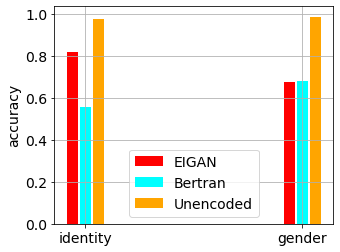

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))

dist_x = [0, 1]
bert_ally = 0.557996
bert_advr = 0.681459
bert = [bert_ally, bert_advr]

eigan_ally = 0.820299
eigan_advr = 0.676186
eigan = [eigan_ally, eigan_advr]

baseline_ally = 0.9749560632688928
baseline_advr = 0.9872583479789103
baseline = [baseline_ally, baseline_advr]

ax1.bar(np.array(dist_x)-0.06, eigan, width=0.05, color='r')
ax1.bar(np.array(dist_x), bert, width=0.05, color='cyan')
ax1.bar(np.array(dist_x)+0.06, baseline, width=0.05, color='orange')
ax1.set_xticks(dist_x)
ax1.legend(['EIGAN', 'Bertran', 'Unencoded'])
ax1.set_xticklabels(['identity', 'gender'])
ax1.set_ylabel('accuracy')
# ax1.set_title('(b)', y=-0.3)
ax1.grid()

# plt.rcParams.update({'font.size': 14})
fig.subplots_adjust(wspace=0.3)
plt.savefig('bertran_facescrub_comparison.png', bbox_inches='tight', dpi=300)

# Compute RCS and compare

In [82]:
from computeBoundClassTensorflow import boundClass

nu = Pu_test.shape[0]
ns = Ps_test.shape[0]
Pus= Pus_test.reshape([nu,ns])
bC = boundClass(Pus_m=Pus, lambda_base=100)
print(bC.ns, bC.IUS, np.log(bC.ns), bC.HU, np.log(bC.nu))
Isx = df_MI['I(S;Y)'][0]

budget_list = np.zeros([df_data.budget.unique().shape[0]+2])
budget_list[0] = Isx
budget_list[1:-1]= df_data.budget.unique()
budget_list[-1:]= 0
ISY_multi_arr, IUY_multi_arr, results_multi_lst, Hu, IUS, ny_list= bC.get_curve(budget_list=budget_list, 
                                                                                n_y_list=[2*nu])

2 0.6833545008280328 0.6931471805599453 5.226073270364424 5.298317366548036
ny 400
budget 0.6622264139930669
budget 0.5
budget 0.4
budget 0.3
budget 0.2
budget 0.1
budget 0.001
budget 0.0


Text(0.5, 0, '$I(U;X|Y)$')

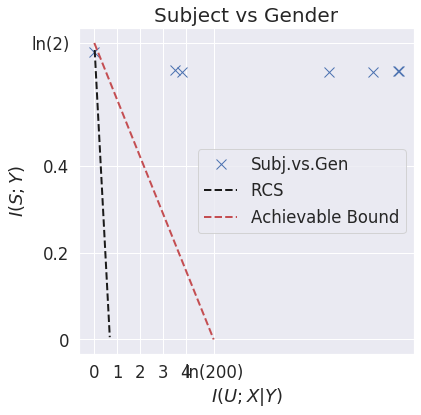

In [84]:
plt.figure(figsize= (6,6))
sns.set(style="darkgrid", font_scale=1.5)
plt.plot(df_MI['I(U;X|Y)'],df_MI['I(S;Y)'],'x',markersize = '10',label = 'Subj.vs.Gen')
plt.plot(Hu - IUY_multi_arr.flatten(),ISY_multi_arr.flatten(),'k--',linewidth = 2,label = 'RCS')
plt.plot([0,Hu],[hs,0],'r--',linewidth = 2,label = 'Achievable Bound')

plt.title('Subject vs Gender',fontsize = 20)
plt.yticks([0,0.2,0.4,hs],['0','0.2','0.4','ln(2)'])
plt.xticks([0,1,2,3,4,Hu],['0','1','2','3','4','ln(200)'])
plt.legend()
# sns.grid()
plt.ylabel(r'$I(S;Y)$')
plt.xlabel(r'$I(U;X|Y)$')